# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils
from backend import loading_utils
from backend import skill_prediction_utils

# Load Basin Attributes for Latitude & Longitude

In [4]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


In [5]:
attributes = loading_utils.load_attributes_file(gauges=gauges)

# Load Return Period Metrics

In [6]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [7]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [8]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Skill Predictability

## Extract Basin Attributes as Classifier/Regression Inputs

In [9]:
# A subset of attributes to use as predictor values. This selection is mostly
# due to challenges in naming all the HydroATLAS variables, and the skill
# is not affected by removing some of the landcover class variables.
ATTRIBUTE_DESCRIPTIVE_NAMES = {
    'calculated_drain_area': 'Drain Area',
    'inu_pc_umn': 'Inundation Percent Min',
    'inu_pc_umx': 'Inundation Percent Max',
    # 'inu_pc_ult': 'Inundation Percent Long Term Maximum',
    'lka_pc_use': 'Precent Lake Area',
    'lkv_mc_usu': 'Lake Volume',
    'rev_mc_usu': 'Reservoir Volume',
    'ria_ha_usu': 'River Area',
    'riv_tc_usu': 'River Volume',
    'ele_mt_uav': 'Elevation',
    'slp_dg_uav': 'Slope',
    'tmp_dc_uyr': 'Air Temperature',
    'pre_mm_uyr': 'Precipitation',
    'pet_mm_uyr': 'PET',
    'aet_mm_uyr': 'AET',
    'ari_ix_uav': 'Aridity Index',
    'cmi_ix_uyr': 'Climate Moisture Index',
    'snw_pc_uyr': 'Snow Cover Extent',
    'for_pc_use': 'Forest Cover Extent',
    'crp_pc_use': 'Cropland Extent',
    'pst_pc_use': 'Pastiure Extent',
    'ire_pc_use': 'Irrigated Area Extent',
    'gla_pc_use': 'Glacier Extent',
    'prm_pc_use': 'Permafrost Extent',
    'pac_pc_use': 'Protected Area Extent',
    'cly_pc_uav': 'Soil Clay Fraction',
    'slt_pc_uav': 'Soil Silt Fraction',
    'snd_pc_uav': 'Soil Sand Fraction',
    'soc_th_uav': 'Soil Organic Carbon',
    'swc_pc_uyr': 'Soil Water Content',
    'kar_pc_use': 'Karst Area Extent',
    'ero_kh_uav': 'Soil Erosion',
    'pop_ct_usu': 'Population Count',
    'ppd_pk_uav': 'Population Density',
    'urb_pc_use': 'Urban Area Extent',
    'nli_ix_uav': 'Nighttime Lights Index',
    # 'rdd_mk_uav': 'Road Density',
    # 'hft_ix_u93': 'Human Footprint 1993',
    # 'hft_ix_u09': 'Human Footprint 2009',
    'gdp_ud_usu': 'GDP',
    # 'latitude': 'latitude',
    # 'longitude': 'longitude',
}

# Select the subset of attributes.
regression_attributes = attributes[ATTRIBUTE_DESCRIPTIVE_NAMES.keys()]
regression_attributes.rename(columns=ATTRIBUTE_DESCRIPTIVE_NAMES, inplace=True)

# Normalize the attributes.
regression_attributes = (regression_attributes - regression_attributes.mean()) / regression_attributes.std()

/tmp/ipykernel_2427216/1900861654.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_attributes.rename(columns=ATTRIBUTE_DESCRIPTIVE_NAMES, inplace=True)


## Hyperparameters for Reliability Score Predictions

In [10]:
# Hyperparamters for reliability score predictions.
lead_time = 0
return_period = 5
metric='F1 Score'

# Predict Which Model is Better Where

There are 36 predictors.
There are 3236 samples.


0it [00:00, ?it/s]

Training fold # 0


1it [00:02,  2.53s/it]

Training fold # 1


2it [00:05,  2.53s/it]

Training fold # 2


3it [00:07,  2.52s/it]

Training fold # 3


4it [00:10,  2.52s/it]

Training fold # 4


5it [00:12,  2.52s/it]

Training fold # 5


6it [00:15,  2.52s/it]

Training fold # 6


7it [00:17,  2.51s/it]

Training fold # 7


8it [00:20,  2.51s/it]

Training fold # 8


9it [00:22,  2.52s/it]

Training fold # 9


10it [00:25,  2.52s/it]


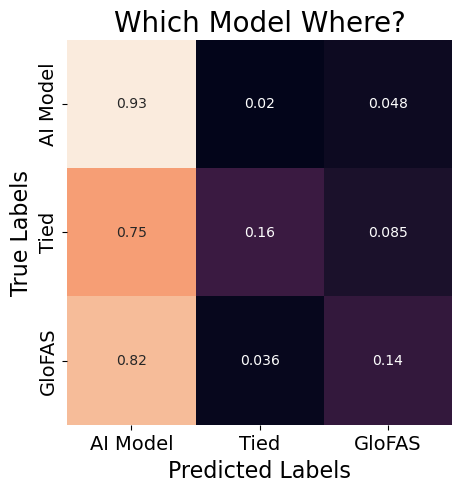

In [11]:
glofas_data = f1s_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].dropna().rename('glofas')
google_data = f1s_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].dropna().rename('google')

regression_data = pd.concat([glofas_data, google_data], axis=1).dropna()
regression_data = (regression_data['glofas'] - regression_data['google']).rename('winner')

bins = [-1e100, -1e-6, 1e-6, 1e100]

metric = 'winner'
x, y = skill_prediction_utils.make_predictors(
    x=regression_attributes,
    y=regression_data,
    metric=metric,
    bins=bins
)

y_hat = skill_prediction_utils.train_kfold(
    x, y,
    classifier=True
#     regression=True
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cm = confusion_matrix(y, y_hat, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2g', ax=ax, cbar=False)
ax.set_aspect('equal', 'box')
ax.set_xlabel('Predicted Labels', fontsize=16)
ax.set_ylabel('True Labels', fontsize=16)
ax.set_title('Which Model Where?', fontsize=20);
ax.xaxis.set_ticklabels(['AI Model', 'Tied', 'GloFAS'], fontsize=14)
ax.yaxis.set_ticklabels(['AI Model', 'Tied', 'GloFAS'], fontsize=14)

evaluation_utils.save_figure(data_paths.PREDICTABILITY_WHICH_MODEL_IS_BETTER)